In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
import scipy as sp
from scipy.stats import linregress, chisquare


import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *


In [2]:
# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

In [3]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_high_corr_skip.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

# counts of pcqtl signals

* eqtls per tissue
* pcqtls per tissue
    * pcqtls broken up by first/middle/last?

In [4]:
pc_susie = load_across_tissues(config, load_pc_susie)
e_susie = load_across_tissues(config, load_e_susie)
clusters = load_across_tissues(config, load_cluster)

In [5]:
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))
tissue_pal

[(0.7215686274509804, 0.22745098039215686, 0.29411764705882354),
 (0.7667820069204152, 0.3172318339100346, 0.26440599769319495),
 (0.81199538638985, 0.40701268742791236, 0.23469434832756633),
 (0.859361783929258, 0.5010688196847367, 0.20356785851595538),
 (0.9045751633986928, 0.5908496732026144, 0.1738562091503268),
 (0.9497885428681276, 0.6806305267204922, 0.1441445597846982),
 (0.993756247597078, 0.7722106881968474, 0.11650903498654364),
 (0.8962245290272972, 0.758000768935025, 0.23341791618608226),
 (0.7986928104575164, 0.7437908496732026, 0.3503267973856209),
 (0.6965167243367936, 0.7289042675893888, 0.4728027681660899),
 (0.5989850057670127, 0.7146943483275663, 0.5897116493656285),
 (0.5014532871972318, 0.7004844290657439, 0.7066205305651673),
 (0.403921568627451, 0.6862745098039216, 0.8235294117647058)]

In [6]:
pc_susie[~pc_susie['cluster_id'].isin(e_susie['cluster_id'])]['cluster_id'].nunique()

31

In [7]:
# create a dataframe with the number of clusters for each tissue 
cs_counts_df = pd.DataFrame({'tissue':tissue_df['Tissue'], 
                       'num_clusters':[sum(clusters['tissue_id'] == t) for t in tissue_df['Tissue']],
                       'num_pc_cs':[pc_susie[pc_susie['tissue_id'] == t]['cs_id'].nunique() for t in tissue_df['Tissue']],
                       'num_pc_clusters':[pc_susie[pc_susie['tissue_id'] == t]['cluster_id'].nunique() for t in tissue_df['Tissue']],
                       'num_e_cs':[e_susie[e_susie['tissue_id'] == t]['cs_id'].nunique() for t in tissue_df['Tissue']],
                        'num_e_clusters':[e_susie[e_susie['tissue_id'] == t]['cluster_id'].nunique() for t in tissue_df['Tissue']],})
cs_counts_df

,tissue,num_clusters,num_pc_cs,num_pc_clusters,num_e_cs,num_e_clusters
0,Adipose_Subcutaneous,175,320,114,334,111
1,Adipose_Visceral_Omentum,181,240,104,253,97
2,Artery_Tibial,163,302,105,327,99
3,Cells_Cultured_fibroblasts,168,294,119,361,117
4,Esophagus_Mucosa,163,292,114,325,110
5,Esophagus_Muscularis,152,240,90,259,88
6,Lung,195,318,122,319,111
7,Muscle_Skeletal,143,275,91,268,87
8,Nerve_Tibial,183,381,136,424,131
9,Skin_Not_Sun_Exposed_Suprapubic,147,256,95,281,91


In [8]:
cs_counts_df['percent_e_clusters'] = cs_counts_df['num_e_clusters']/ cs_counts_df['num_clusters'] * 100
cs_counts_df['percent_pc_clusters'] = cs_counts_df['num_pc_clusters']/ cs_counts_df['num_clusters'] * 100


In [9]:
cs_counts_df['num_pc_clusters'].sum()/cs_counts_df['num_clusters'].sum()

0.6615952051636699

In [10]:
cs_counts_df['num_e_clusters'].sum()/cs_counts_df['num_clusters'].sum()

0.6353158137390502

In [11]:
from scipy.stats import ttest_rel, ranksums

ttest_rel(cs_counts_df['num_e_cs'], cs_counts_df['num_pc_cs'])

TtestResult(statistic=4.494512369191843, pvalue=0.0007336301993913731, df=12)

/local/scratch/klawren/slrmtmp.46793668/ipykernel_77621/2715874390.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


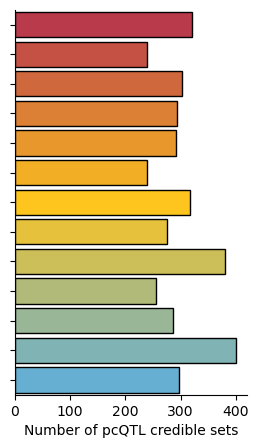

In [12]:
# plot showing number of pc credible sets in each tissue

fig, ax = plt.subplots(figsize=(3,5))

ax = sns.barplot(cs_counts_df, x='num_pc_cs', hue='tissue', y='tissue', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.set_xlabel('Number of pcQTL credible sets')
ax.set_ylabel('')

# remove y tick labels
ax.set_yticklabels('')
ax.set_ylabel('')

plt.show()


/local/scratch/klawren/slrmtmp.46793668/ipykernel_77621/3238361996.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


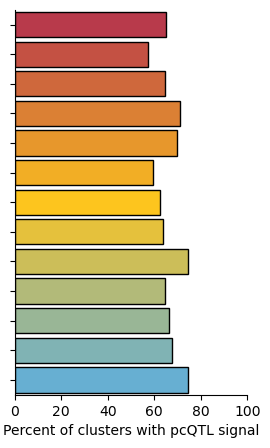

In [13]:
# plot showing number of clusters wth a pc in each tissue

fig, ax = plt.subplots(figsize=(3,5))

ax = sns.barplot(cs_counts_df, x='percent_pc_clusters', hue='tissue', y='tissue', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.set_xlabel('Percent of clusters with pcQTL signal')
ax.set_ylabel('')
ax.set_xlim(0, 100)


# remove y tick labels
ax.set_yticklabels('')
ax.set_ylabel('')

plt.show()

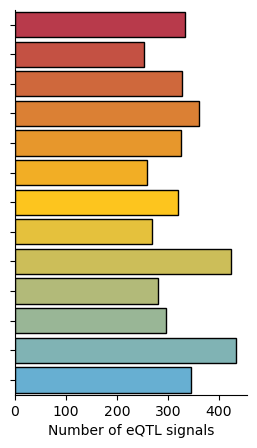

In [14]:
# plot showing number of clusters in each tissue

fig, ax = plt.subplots(figsize=(3,5))

ax = sns.barplot(cs_counts_df, x='num_e_cs', hue='tissue', y='tissue', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# remove y tick labels
ax.set_yticklabels('')
ax.set_ylabel('')

ax.set_xlabel('Number of eQTL signals')
ax.set_ylabel('')

plt.show()


/local/scratch/klawren/slrmtmp.46793668/ipykernel_77621/137747467.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


TtestResult(statistic=-6.158414571861049, pvalue=4.883715420244699e-05, df=12)

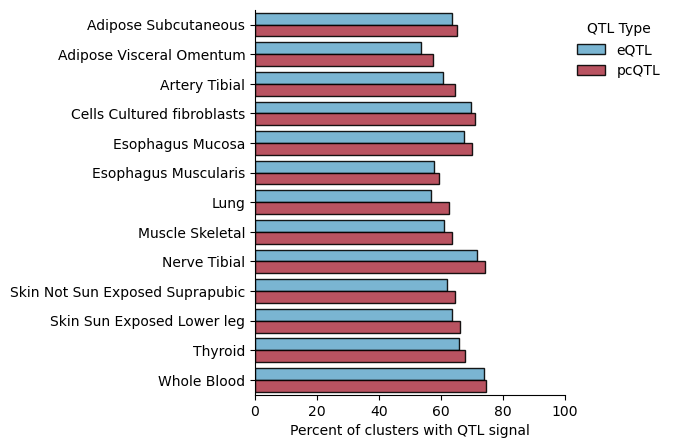

In [15]:
melted = cs_counts_df.melt(id_vars='tissue', value_vars=['percent_e_clusters', 'percent_pc_clusters'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(4,5))

sns.barplot(melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'percent_e_clusters':'#67AFD2', 'percent_pc_clusters':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['eQTL', 'pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

ax.set_ylabel('')
ax.set_xlabel('Percent of clusters with QTL signal')
ax.set_xlim(0,100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

/local/scratch/klawren/slrmtmp.46793668/ipykernel_77621/755826556.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=-6.158414571861049, pvalue=4.883715420244699e-05, df=12)

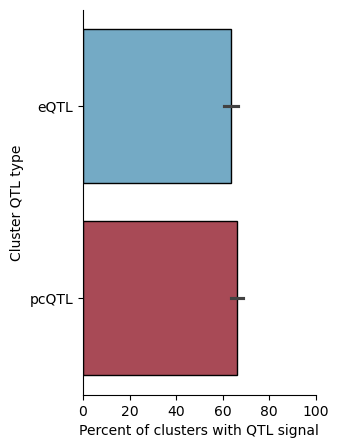

In [16]:
melted = cs_counts_df.melt(id_vars='tissue', value_vars=['percent_e_clusters', 'percent_pc_clusters'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(3,5))

sns.barplot(melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'percent_e_clusters':'#67AFD2', 'percent_pc_clusters':'#B83A4B'})


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Percent of clusters with QTL signal')
ax.set_xlim(0,100)
ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

/local/scratch/klawren/slrmtmp.46793668/ipykernel_77621/3126231812.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=-6.158414571861049, pvalue=4.883715420244699e-05, df=12)

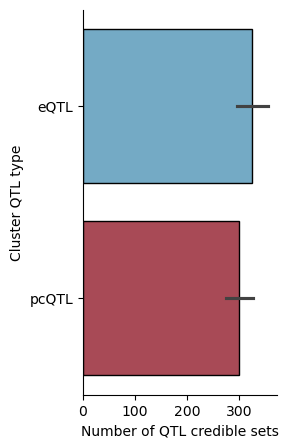

In [17]:
melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_e_cs', 'num_pc_cs'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(2.5,5))

sns.barplot(melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'num_e_cs':'#67AFD2', 'num_pc_cs':'#B83A4B'})


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')
ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

In [18]:
# e and pcqtl signals in each 
combined_susie = pd.concat([e_susie, pc_susie], names=['type', 'idx'], keys=['eQTL', 'pcQTL']).reset_index(drop=0).drop(columns=['idx'])
credible_sets = combined_susie.groupby(['cs_id', 'tissue_id', 'cluster_id']).agg({'type':'first', 'lead_variant_id':'first'}).reset_index()
# add lead var overlap information
lead_var_grouped = credible_sets.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 'type':list})
lead_var_grouped['num_eqtl_samelead'] = lead_var_grouped['type'].astype(str).str.count('eQTL')
lead_var_grouped['num_pcqtl_samelead'] = lead_var_grouped['type'].astype(str).str.count('pcQTL')
lead_var_grouped['multiple_e'] = lead_var_grouped['num_eqtl_samelead'] > 1
lead_var_grouped['multiple_pc'] = lead_var_grouped['num_pcqtl_samelead'] > 1
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'Shared', 'eQTL only'), 'pcQTL only')
credible_sets = lead_var_grouped.explode(['cs_id', 'type'])
credible_sets['has_pcqtl'] = credible_sets['num_pc_samelead'] > 0

/local/scratch/klawren/slrmtmp.46793668/ipykernel_77621/2581727584.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(multiple_melt, ax = ax, hue='type', y='type', x='cs_id', edgecolor='k', palette={'eQTL':'#016895', 'pcQTL':'#8C1515'}, ci=None)
/local/scratch/klawren/slrmtmp.46793668/ipykernel_77621/2581727584.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


Text(0.5, 0, 'Number of QTL credible sets')

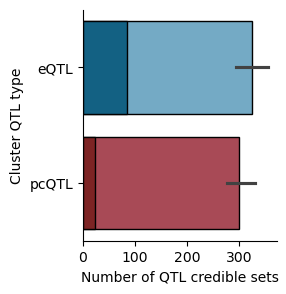

In [19]:
fig, ax = plt.subplots(figsize=(2.5,3))
melted.loc[melted['type'] == 'num_e_cs', 'type'] = 'eQTL'
melted.loc[melted['type'] == 'num_pc_cs', 'type'] = 'pcQTL'
sns.barplot(melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'eQTL':'#67AFD2', 'pcQTL':'#B83A4B'})
multiple_credible_sets = credible_sets[(credible_sets['multiple_e'] & (credible_sets['type']=='eQTL'))| (credible_sets['multiple_pc'] & (credible_sets['type']=='pcQTL'))]
multiple_melt = multiple_credible_sets.groupby(['type', 'tissue_id']).agg({'cs_id':'nunique'})
sns.barplot(multiple_melt, ax = ax, hue='type', y='type', x='cs_id', edgecolor='k', palette={'eQTL':'#016895', 'pcQTL':'#8C1515'}, ci=None)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')

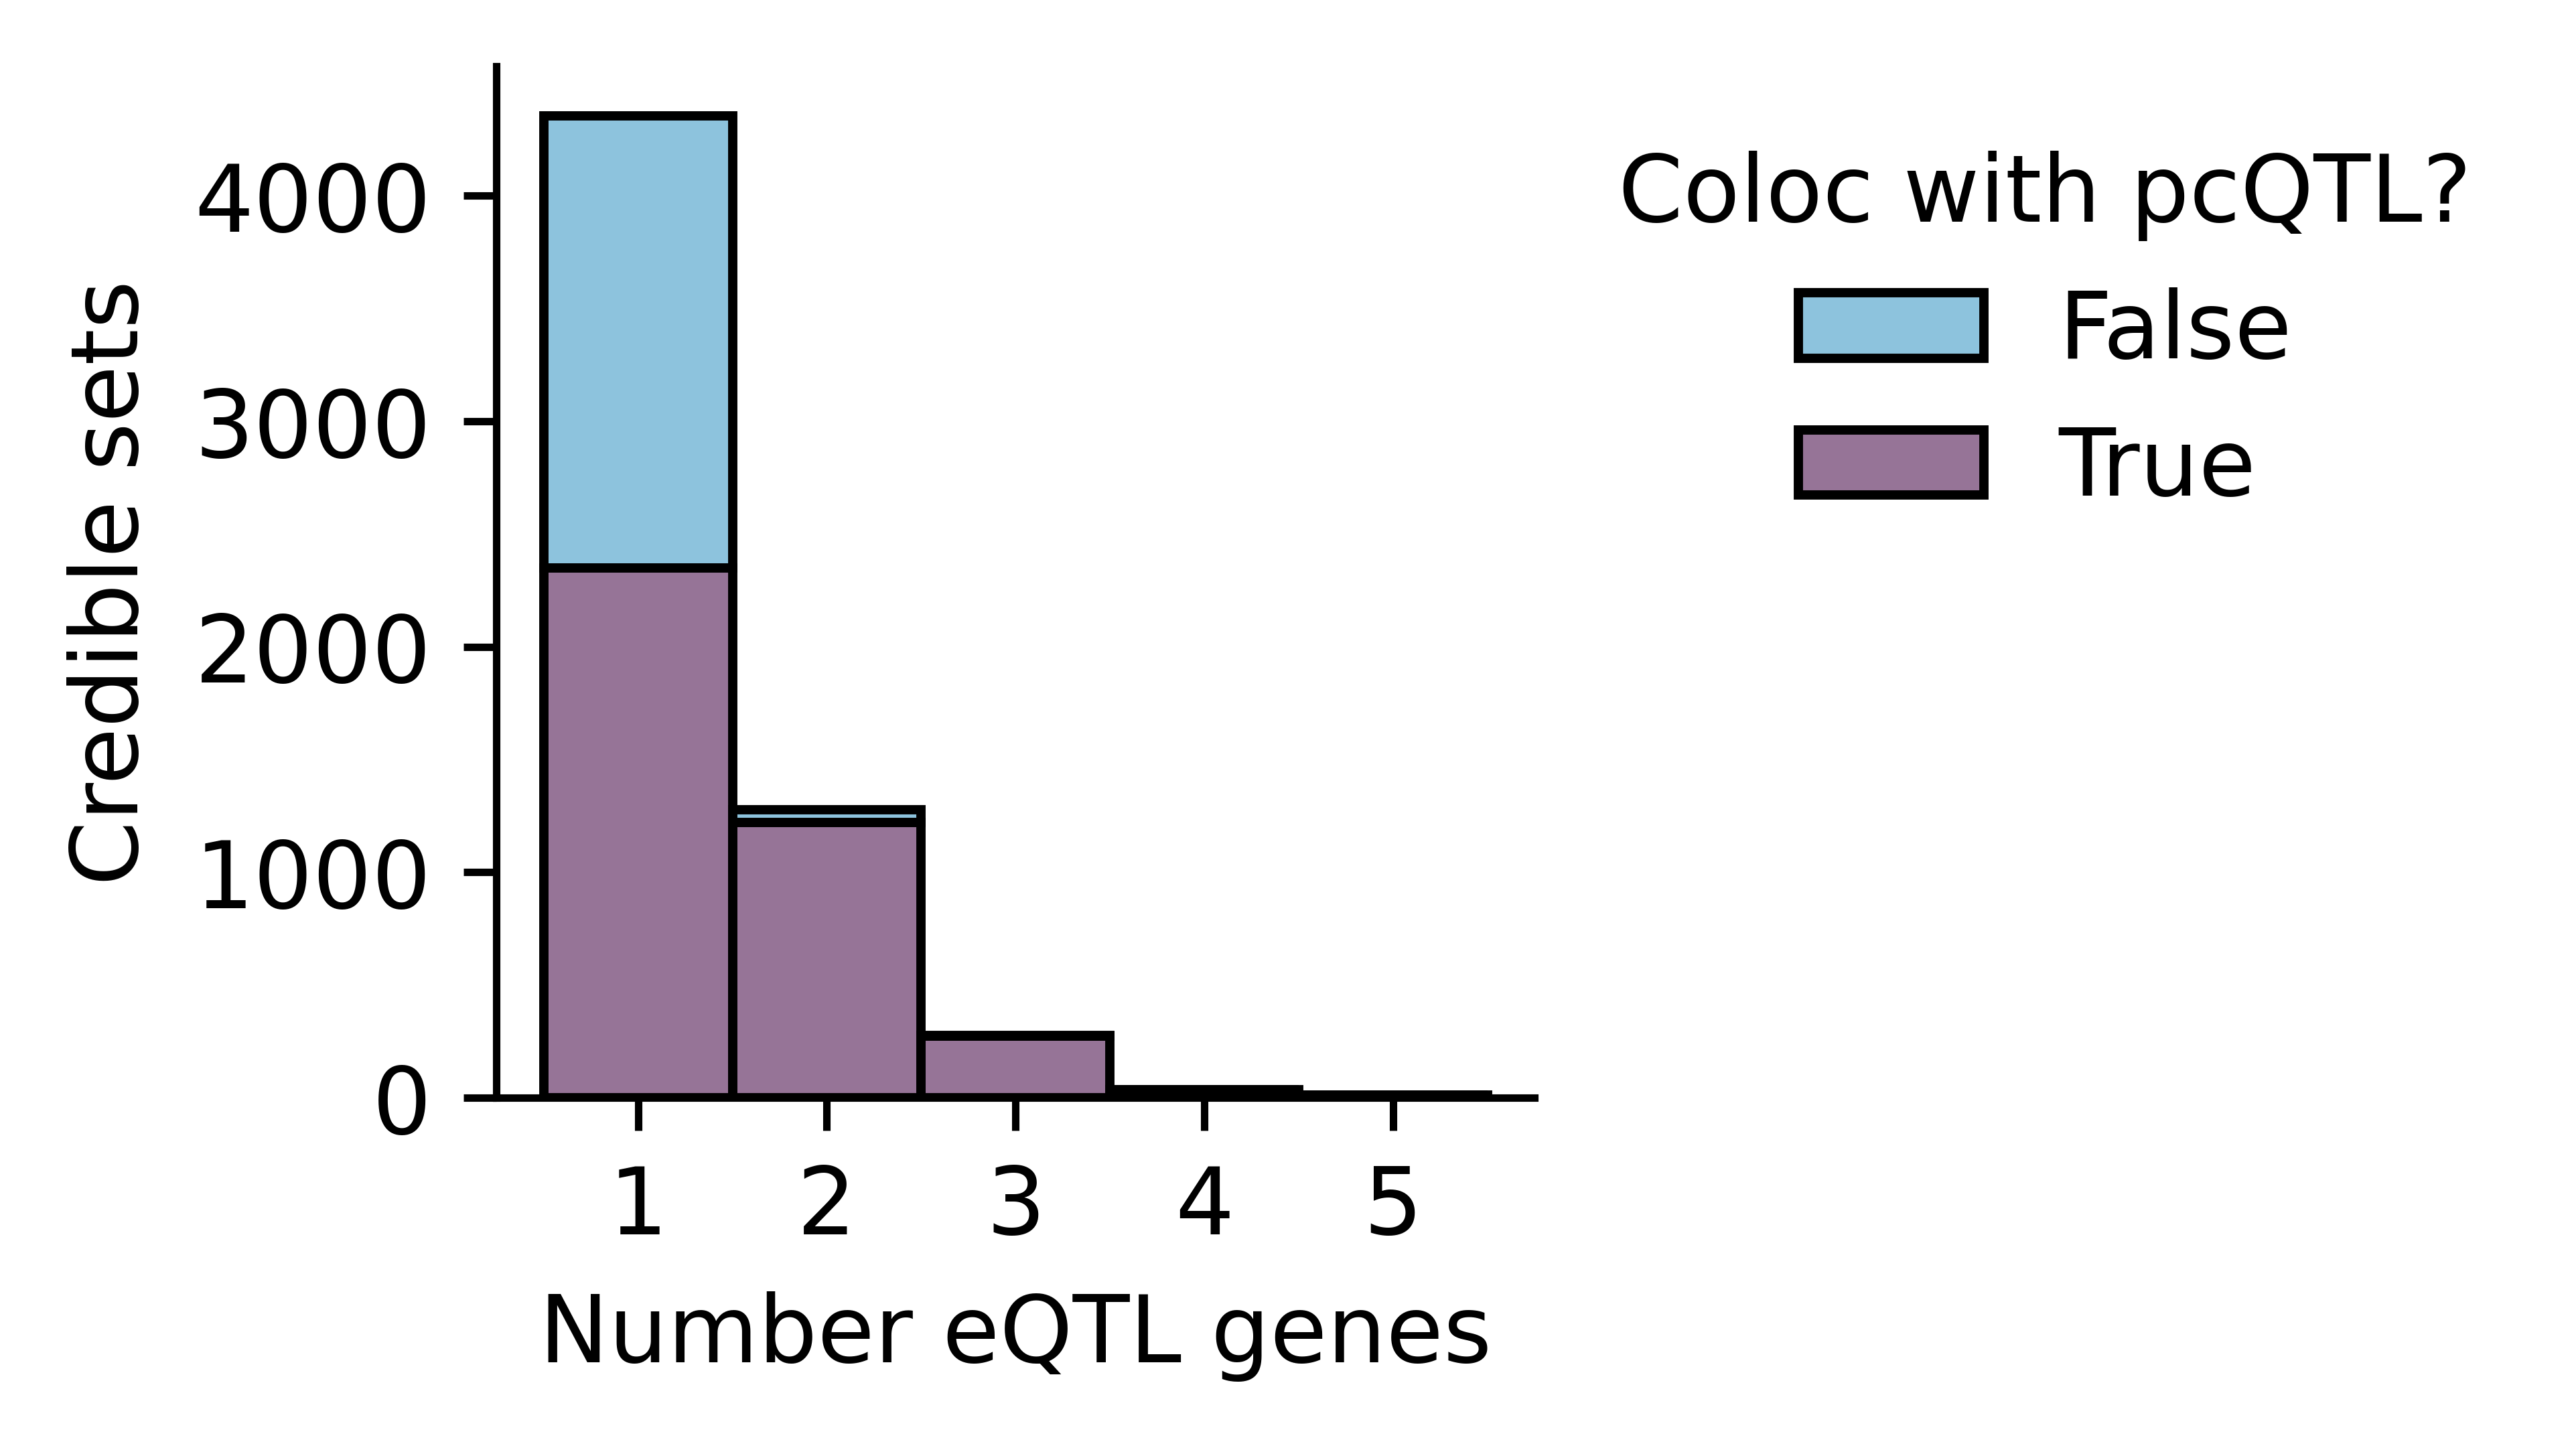

In [30]:
mpl.rcParams['figure.dpi']= 1000
fig, ax = plt.subplots(figsize=(2,2))
sns.histplot(credible_sets[(credible_sets['num_e_samelead'] > 0)], x='num_e_samelead', hue='has_pcqtl', 
             multiple='stack', bins=range(1,7), palette={False:'#67AFD2', True:'#734675'},)

ax.set_xlabel('Number eQTL genes')
ax.set_ylabel('Credible sets')


# Change legend title
leg = ax.get_legend()
leg.set_title('Coloc with pcQTL?')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

ax.set_xticks([1.5,2.5,3.5,4.5, 5.5], [1,2,3,4, 5])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

mpl.rcParams['figure.dpi']= 100


/local/scratch/klawren/slrmtmp.46756152/ipykernel_24135/3868885298.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


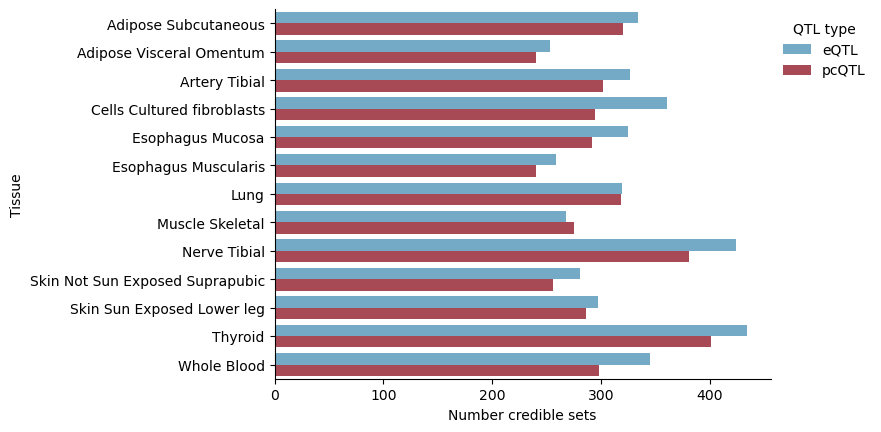

In [22]:
ax = sns.countplot(credible_sets, hue='type', y='tissue_id', palette={'eQTL':'#67AFD2', 'pcQTL':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number credible sets')
ax.set_ylabel('Tissue')
plt.legend(title='QTL type')
plt.gca().get_legend().set_frame_on(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()


/local/scratch/klawren/slrmtmp.46756152/ipykernel_24135/2212606116.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


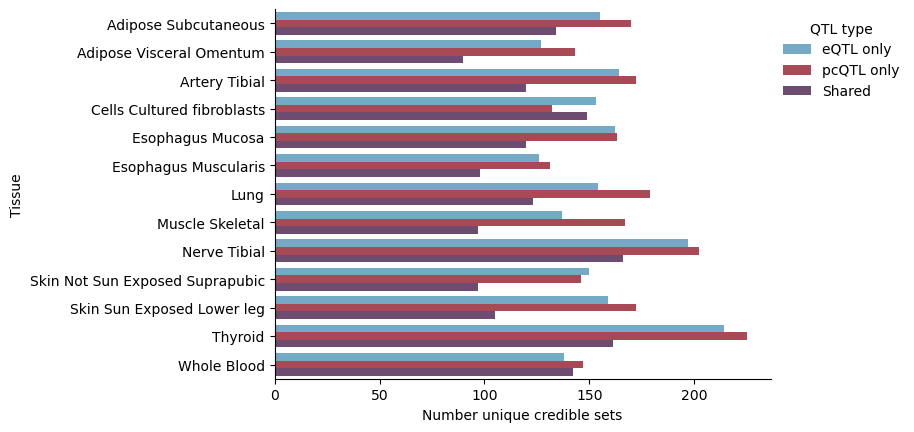

In [23]:
ax = sns.countplot(lead_var_grouped, hue='exclusive_label', y='tissue_id', palette={'eQTL only':'#67AFD2', 'pcQTL only':'#B83A4B', 'Shared':'#734675'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number unique credible sets')
ax.set_ylabel('Tissue')
plt.legend(title='QTL type')
plt.gca().get_legend().set_frame_on(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

In [24]:
ttest_rel(lead_var_grouped[lead_var_grouped['exclusive_label']=='pcQTL only'].reset_index()['tissue_id'].value_counts(),
          lead_var_grouped[lead_var_grouped['exclusive_label']=='eQTL only'].reset_index()['tissue_id'].value_counts())


TtestResult(statistic=6.158548755370638, pvalue=4.8827243482851196e-05, df=12)

/local/scratch/klawren/slrmtmp.46756152/ipykernel_24135/3126231812.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=-6.158414571861049, pvalue=4.883715420244699e-05, df=12)

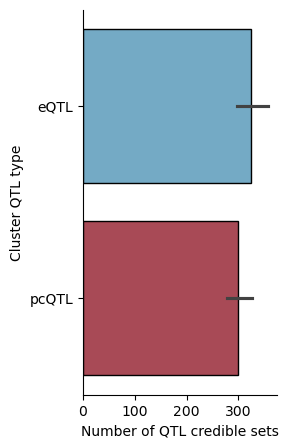

In [25]:
melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_e_cs', 'num_pc_cs'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(2.5,5))

sns.barplot(melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'num_e_cs':'#67AFD2', 'num_pc_cs':'#B83A4B'})


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')
ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

/local/scratch/klawren/slrmtmp.46756152/ipykernel_24135/2114478265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_credible_sets['type'] = 'multiple ' + multiple_credible_sets['type'].astype(str) + 's'
/local/scratch/klawren/slrmtmp.46756152/ipykernel_24135/2114478265.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


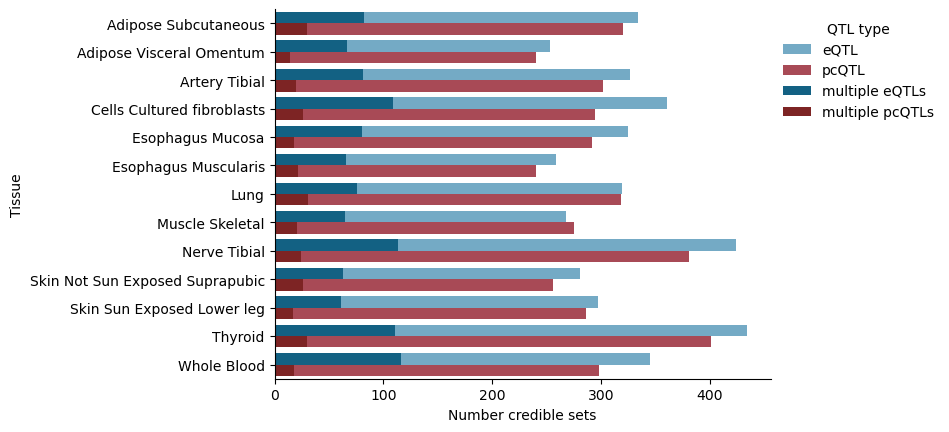

In [26]:
# the full amount
ax = sns.countplot(credible_sets, hue='type', y='tissue_id', palette={'eQTL':'#67AFD2', 'pcQTL':'#B83A4B'}, order=tissue_ids)
# the multiple ones colored
multiple_credible_sets = credible_sets[(credible_sets['multiple_e'] & (credible_sets['type']=='eQTL'))| (credible_sets['multiple_pc'] & (credible_sets['type']=='pcQTL'))]
multiple_credible_sets['type'] = 'multiple ' + multiple_credible_sets['type'].astype(str) + 's'
sns.countplot(multiple_credible_sets, hue='type', y='tissue_id', palette={'multiple eQTLs':'#016895', 'multiple pcQTLs':'#8C1515'}, ax=ax, order=tissue_ids)


# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number credible sets')
ax.set_ylabel('Tissue')
plt.legend(title='QTL type')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.gca().get_legend().set_frame_on(False)

plt.show()


/local/scratch/klawren/slrmtmp.46756152/ipykernel_24135/3580127481.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


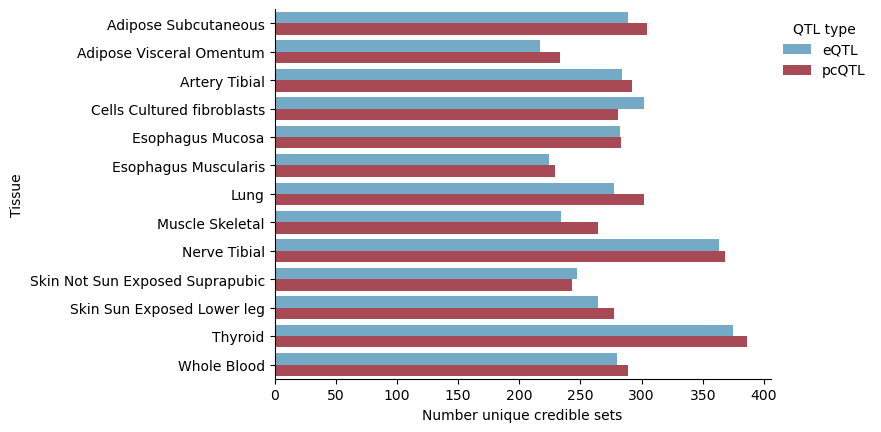

In [27]:
# combined for unique signals
deduplicated_lead_vars = credible_sets['type'].reset_index().drop_duplicates()

ax = sns.countplot(deduplicated_lead_vars, hue='type', y='tissue_id', palette={'eQTL':'#67AFD2', 'pcQTL':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number unique credible sets')
ax.set_ylabel('Tissue')
plt.legend(title='QTL type')
plt.gca().get_legend().set_frame_on(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()


In [40]:
unique_melt.loc['eQTL']

,lead_variant_id
tissue_id,
Adipose_Subcutaneous,288
Adipose_Visceral_Omentum,216
Artery_Tibial,284
Cells_Cultured_fibroblasts,302
Esophagus_Mucosa,282
Esophagus_Muscularis,224
Lung,277
Muscle_Skeletal,234
Nerve_Tibial,363


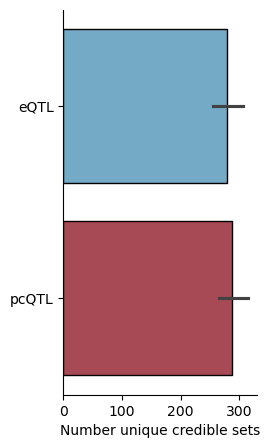

TtestResult(statistic=array([-2.43363277]), pvalue=array([0.03152258]), df=array([12]))

In [43]:
# combined for unique signals
fig, ax = plt.subplots(figsize=(2.5,5))

deduplicated_lead_vars = credible_sets['type'].reset_index().drop_duplicates()
unique_melt = deduplicated_lead_vars.groupby(['type', 'tissue_id']).agg({'lead_variant_id':'nunique'})
sns.barplot(unique_melt, ax = ax, hue='type', y='type', x='lead_variant_id', edgecolor='k', palette={'eQTL':'#67AFD2', 'pcQTL':'#B83A4B'})

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number unique credible sets')
ax.set_ylabel('')
plt.show()

ttest_rel(unique_melt.loc['eQTL'], unique_melt.loc['pcQTL'])


/local/scratch/klawren/slrmtmp.46753452/ipykernel_30440/1375307481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_credible_sets['type'] = 'shared'
/local/scratch/klawren/slrmtmp.46753452/ipykernel_30440/1375307481.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


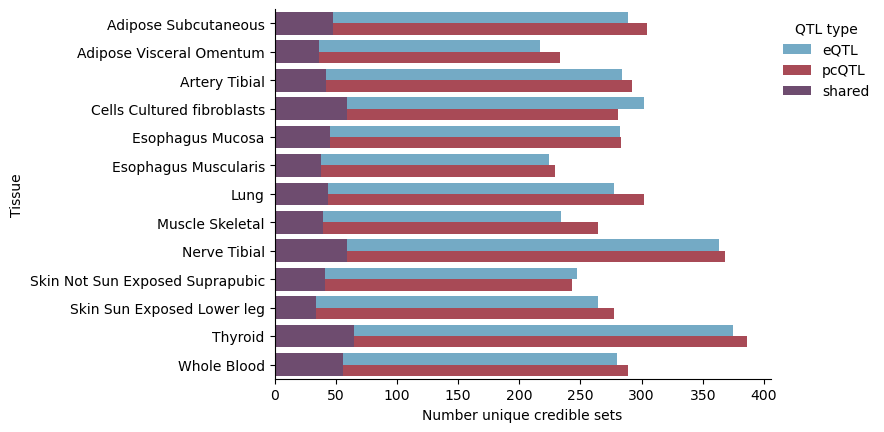

In [26]:
# the full amount
ax = sns.countplot(credible_sets['type'].reset_index().drop_duplicates(), hue='type', y='tissue_id', palette={'eQTL':'#67AFD2', 'pcQTL':'#B83A4B'}, order=tissue_ids)
# the multiple ones colored
shared = credible_sets[(credible_sets['type']=='pcQTL')]
multiple_credible_sets['type'] = 'shared'
sns.countplot(multiple_credible_sets['type'].reset_index().drop_duplicates(), hue='type', y='tissue_id', palette={'shared':'#734675'}, ax=ax, order=tissue_ids)


# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number unique credible sets')
ax.set_ylabel('Tissue')
plt.legend(title='QTL type')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.gca().get_legend().set_frame_on(False)

plt.show()


Chi-squared Statistic: 1.7281093517390715, p-value: 0.18865253099621546


/local/scratch/klawren/slrmtmp.46753452/ipykernel_30440/415285758.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(deduplicated_lead_vars, y='type', palette={'eQTL':'#67AFD2', 'pcQTL':'#B83A4B'})


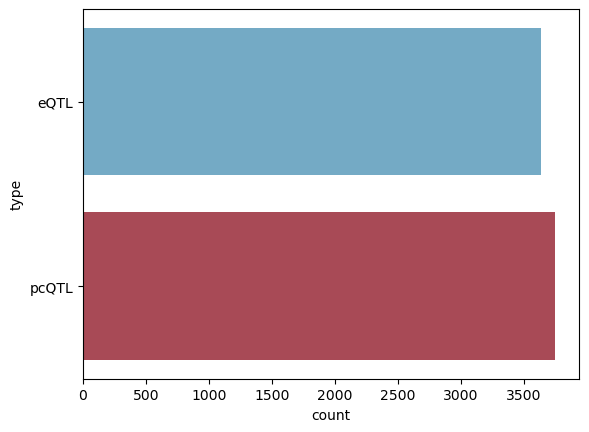

In [20]:
ax = sns.countplot(deduplicated_lead_vars, y='type', palette={'eQTL':'#67AFD2', 'pcQTL':'#B83A4B'})
# Observed counts
observed = deduplicated_lead_vars.value_counts('type').values

# Perform the Chi-squared test
chi2_stat, p_value = chisquare(observed)
print(f"Chi-squared Statistic: {chi2_stat}, p-value: {p_value}")

In [223]:
clusters = load_across_tissues(config, load_clusters_annotated)

In [224]:
clusters['has_eqtl'] = clusters['cluster_id'].isin(deduplicated_lead_vars[deduplicated_lead_vars['type']=='eQTL']['cluster_id'])
clusters['has_pcqtl'] = clusters['cluster_id'].isin(deduplicated_lead_vars[deduplicated_lead_vars['type']=='pcQTL']['cluster_id'])

In [225]:
from scipy.stats import chi2_contingency

# Observed counts
contingency_table = [clusters['has_pcqtl'].value_counts().values, clusters['has_eqtl'].value_counts().values]
print(contingency_table)
# Perform the Chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2_stat}, p-value: {p_value}, Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

[array([1796,  373]), array([1764,  405])]
Chi-squared Statistic: 1.5051623292221483, p-value: 0.21987875861221784, Degrees of Freedom: 1
Expected Frequencies: 
[[1780.  389.]
 [1780.  389.]]
